# **Malaria Cell Images Analysis And Prediction**

Malaria is a mosquito-borne infectious disease that affects humans and other animals. Malaria causes symptoms that typically include fever, tiredness, vomiting, and headaches. In severe cases it can cause yellow skin, seizures, coma or death. While the disease is uncommon in temperate climates, malaria is still common in tropical and subtropical countries. World health officials are trying to reduce the incidence of malaria by distributing bed nets to help protect people from Mosquito bites as they sleep. Scientists around the world are working to develop a vaccine to prevent malaria. Malaria is caused by single-celled micro-organisms of the Plasmodium group. The disease is most commonly spread by an infected Female Anopheles mosquito. The mosquito bite introduces the parasites from the mosquito's saliva into a person's blood. The parasites then travel to the liver where they mature and reproduce.

In [1]:
import os 
import cv2 
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import Dense 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers import MaxPooling2D 

In [2]:
# Getting the path to the dataset directory 
# Getting the path to the working directory 
workingDir = "/kaggle/input/cell-images-for-detecting-malaria"
PATH = os.path.sep.join([workingDir, "cell_images"])

# Getting the path ot the training directory 
train_dir = os.path.join(PATH, "cell_images")

# Getting the path to the validation directory 
validation_dir = os.path.join(PATH, "cell_images")

In [3]:
# Getting the path to the directory for the parasitized training cell images and 
# the getting the path to the directory for the uninfected training cell images 
parasitized_train_dir = os.path.join(train_dir, "Parasitized")
uninfected_train_dir = os.path.join(train_dir, "Uninfected")

# Getting the path to the directory for the parasitized validation cell images and 
# the path to the directory for the uninfected validation cell images 
parasitized_val_dir = os.path.join(validation_dir, "Parasitized") 
uninfected_val_dir = os.path.join(validation_dir, "Uninfected")

# Understanding The Data

Let us look at how many parasitized and ininfected cell images are present in both the training and validation folders

In [4]:
# Getting the number of images present in the parasitized training directory and the 
# number of images present in the uninfected training directory 
parasitized_images = len(os.listdir(parasitized_train_dir))
uninfected_images = len(os.listdir(uninfected_train_dir))

# Getting the number of images present in the parasitized validation directory and the 
# number of images present in the uninfected validation directory 
parasitized_images_val = len(os.listdir(parasitized_val_dir)) 
uninfected_images_val = len(os.listdir(uninfected_val_dir)) 

# Getting the sum of both the training images and validation images 
total_train = parasitized_images + uninfected_images  
total_val = parasitized_images_val + uninfected_images_val 

# Displaying the results for Training images  
print("Total Training parasitized images: {}".format(parasitized_images)); 
print("Total Training uninfected images: {}".format(uninfected_images)); 
print("__________________________________________________________________________________________________________\n");

# Displaying the results for Validation images  
print("Total Validation parasitized images: {}".format(parasitized_images_val)); 
print("Total Validation uninfected images: {}".format(uninfected_images_val)); 
print("__________________________________________________________________________________________________________\n"); 

# Displaying the total values for the images in both the training and validation directory 
print("Total Train: {}".format(total_train)); 
print("Total Validation: {}".format(total_val)); 

Total Training parasitized images: 13780
Total Training uninfected images: 13780
__________________________________________________________________________________________________________

Total Validation parasitized images: 13780
Total Validation uninfected images: 13780
__________________________________________________________________________________________________________

Total Train: 27560
Total Validation: 27560


In [5]:
# Setting the batch size, number of epochs, the image height and width parameters 
batch_size = 2000
epochs = 20 
IMG_HEIGHT = 98 
IMG_WIDTH = 98 

# Data Preparation

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Firstly read the image from disk or in the working directory
2. Decode the contents of the images and convert it into a proper grid format as their RGB content.
3. Convert the images then into floating point tensors
4. Rescale the tensors from valies between the range of 0 and 255 to values from 0 to 1, because neural networks take in small input values.

All this tasks can be done whith the ImageDataGenerator class which is providec by the tf.keras module. It can read images from disk and preprocess them into proper tensors. It will alos set up generators that also convert this images into batches of tensors which are helpful when trainning the neural network. After defining the generators for the training and validation images, the flow_from_directory method load the images from the disk, applies rescaing, and resized the imaes into the required dimensions.

In [6]:
# Creating the generator for our training images data and for our validation images data 
train_image_gen = ImageDataGenerator(rescale = 1.0 / 255.0)
validation_image_gen = ImageDataGenerator(rescale = 1.0 / 255.0) 

# Getting the training images from the train directory by using the flow from directory method 
# to load the images with a stated batch size and an image height and width. 
train_data_gen = train_image_gen.flow_from_directory(batch_size = batch_size, 
                                                    directory = train_dir, 
                                                    shuffle = True, 
                                                    target_size = (IMG_HEIGHT, IMG_WIDTH), 
                                                    class_mode = "binary")

# Getting the validation images from the validation directory by using the flow from_from_directory method 
# to load the images, shuffle them, and resize them with an image height and a specified width value. 
validation_data_gen =validation_image_gen.flow_from_directory(batch_size = batch_size, 
                                                             directory = validation_dir, 
                                                             shuffle = True, 
                                                             target_size = (IMG_HEIGHT, IMG_WIDTH), 
                                                             class_mode = "binary")

Found 27558 images belonging to 2 classes.
Found 27558 images belonging to 2 classes.


# Visualize The Training Images

The training images can be visualized by extracting a batch of images from the training generator. The next function returns a batch of images from the dataset. The return value of the next function is in form of the (X_train, y_train) where X_train is the training features and y_train is its labels.

So here, we plot both the training images with it respective labels.

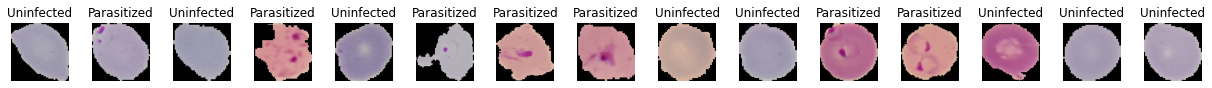

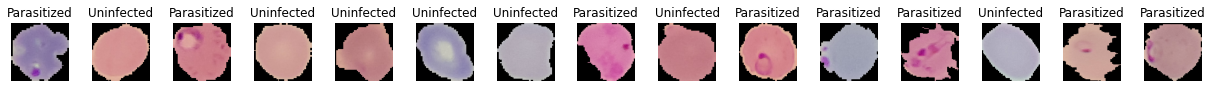

In [7]:
# Getting the images and labels from the training data generator 
sample_training_images, train_label = next(train_data_gen) 

# Getting the images and labels from the training data generator 
sample_training_images, train_label = next(train_data_gen) 

# Getting the images and labels from the validation data generator 
sample_validation_images, val_label = next(validation_data_gen) 

# Defining a function to plot the images in the form of a grid with 1 row and 15 columns where the 
# Images are placed in each column with their respective labels 
def plotImages(images, batch=None): 
    global train_data_gen 
    fig, axes = plt.subplots(1, 15, figsize=(17, 20))
    # Flatten the axes 
    axes = axes.flatten() 
    # Creating a loop to loop throught the image directory and plot the images 
    for img, ax, labels in zip(images, axes, batch): 
        # Extracting the respective labels or tags for the plotted images 
        for key, value in train_data_gen.class_indices.items(): 
            # Converting the labels into integer values 
            labels = int(labels) 
            # Plotting the images by the label key value for the respective goten integer value 
            if value == labels: 
                ax.set_title(key) 
                ax.imshow(img) 
                ax.axis("off")
                
    # Displaying the plot 
    plt.tight_layout() 
    plt.show() 
    
    
# Plotting 15 random images from the sample training images with its respective labels 
plotImages(sample_training_images[:15], train_label[:15])

# Plotting 15 images from the sample validation images 
plotImages(sample_validation_images[:15], val_label[:15])

In [8]:
# Displaying the shape of the sample training image data 
print("Input Shape: {}".format(sample_training_images.shape)); 

# Displaying the shape of the output training images label 
print("Output Shape: {}".format(train_label.shape)); 

# Displaying the shape of the validation images data 
print("Validation Input Shape: {}".format(sample_validation_images.shape)); 

# Displaying the shape of the sample output validation images label 
print("Validation Output Shape: {}".format(val_label.shape)); 

Input Shape: (2000, 98, 98, 3)
Output Shape: (2000,)
Validation Input Shape: (2000, 98, 98, 3)
Validation Output Shape: (2000,)


In [9]:
# Displaying the label class and its respective key value for the class 
labelClass = list(train_data_gen.class_indices.items())

# Showing the values 
print("Label Class: {}".format(labelClass))

Label Class: [('Parasitized', 0), ('Uninfected', 1)]


# Model Building

The model consists of three convolution blocks with a max pool layer in each of them. There is a fully connected layer with 512 units on top of its that is activated by a relu activation function.

In [10]:
# Building the model 
def ModelDefined(dim): 
    # Using the tensorflow Sequential module to create the model then add some specific 
    # Parameters. 
    model = Sequential([
        Conv2D(16, 3, padding="same", activation="relu", input_shape=dim),
        MaxPooling2D(), 
        Conv2D(32, 3, padding="same", activation="relu"), 
        MaxPooling2D(), 
        Conv2D(64, 3, padding="same", activation="relu"), 
        MaxPooling2D(), 
        Flatten(), 
        Dense(512, activation="relu"), 
        Dense(1)
        
    ])
    
    # Compiling the model and setting the optimizer to be adam, and a loss function of binary crossentropy 
    model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                 metrics=["accuracy"])
    
    # Returning the compiled model to be loaded easily 
    return model 


# Setting the dimensions to be passed into the model function 
dim = (IMG_HEIGHT, IMG_WIDTH, 3); 

# Creating the model 
model = ModelDefined(dim); 

# Displaying the summary of the model 
model.summary(); 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 49, 49, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0

In [11]:
# Training the model on the input data by using the fit_generator function 
H = model.fit_generator(train_data_gen, steps_per_epoch = total_train // batch_size, 
                       epochs = epochs, 
                       validation_data = validation_data_gen, 
                       validation_steps = total_val // batch_size) 


# Saving the model for further uses 
modelName = "MalariaModel.h5" 
model.save_weights(modelName);

Epoch 1/20
13/13 [==============================] - 601s 46s/step - loss: 0.9467 - accuracy: 0.5153 - val_loss: 0.6910 - val_accuracy: 0.4995
Epoch 2/20
13/13 [==============================] - 224s 17s/step - loss: 0.6874 - accuracy: 0.4998 - val_loss: 0.6749 - val_accuracy: 0.5001
Epoch 3/20
13/13 [==============================] - 216s 17s/step - loss: 0.6509 - accuracy: 0.5496 - val_loss: 0.6228 - val_accuracy: 0.6054
Epoch 4/20
13/13 [==============================] - 215s 17s/step - loss: 0.6194 - accuracy: 0.6445 - val_loss: 0.5990 - val_accuracy: 0.6438
Epoch 5/20
13/13 [==============================] - 229s 18s/step - loss: 0.5897 - accuracy: 0.6734 - val_loss: 0.5789 - val_accuracy: 0.6548
Epoch 6/20
13/13 [==============================] - 211s 16s/step - loss: 0.5654 - accuracy: 0.6988 - val_loss: 0.5477 - val_accuracy: 0.7155
Epoch 7/20
13/13 [==============================] - 226s 17s/step - loss: 0.5442 - accuracy: 0.7141 - val_loss: 0.5212 - val_accuracy: 0.7442
Epoch 

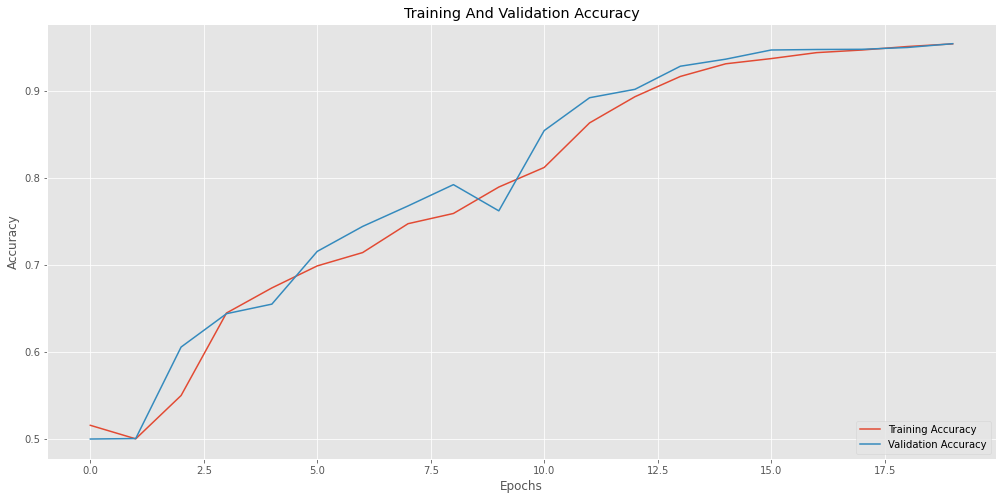

In [12]:
# Setting the type of plot style for the graph 
plt.style.use("ggplot") 

# Getting the accuracy and the validation accuracy 
accuracy = H.history["accuracy"]
validation_accuracy = H.history["val_accuracy"]

# Getting the loss and the validation loss 
loss = H.history["loss"]
validation_loss = H.history["val_loss"] 

# Getting the epochs range 
epochs_range = range(epochs) 

# Plotting the first graph for accuracy 
plt.figure(figsize=(17, 8)); 
plt.plot(epochs_range, accuracy, label = "Training Accuracy"); 
plt.plot(epochs_range, validation_accuracy, label = "Validation Accuracy"); 
plt.xlabel("Epochs"); 
plt.ylabel("Accuracy"); 
plt.legend(loc="lower right"); 
plt.title("Training And Validation Accuracy"); 
plt.show();

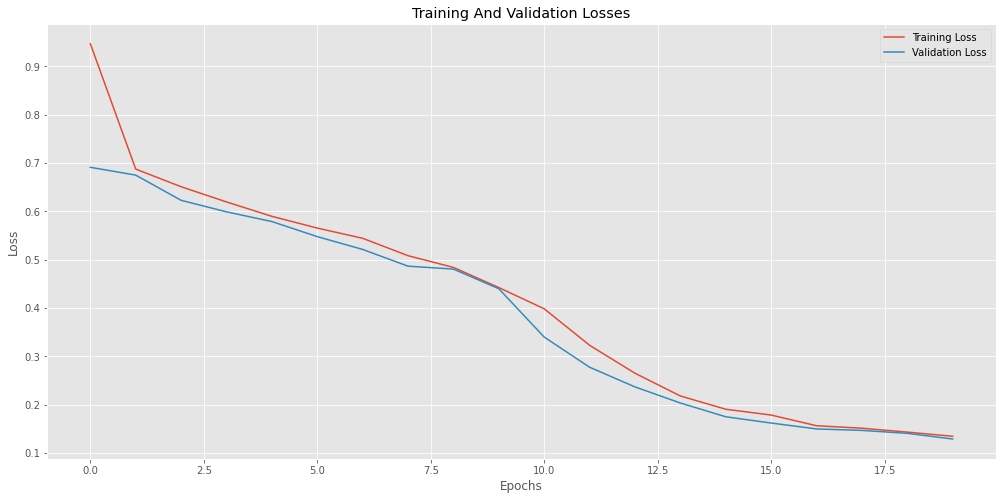

In [13]:
# Plotting the second graph for loss 
plt.figure(figsize=(17, 8)) 
plt.plot(epochs_range, loss, label = "Training Loss"); 
plt.plot(epochs_range, validation_loss, label = "Validation Loss"); 
plt.xlabel("Epochs"); 
plt.ylabel("Loss"); 
plt.legend(loc="upper right"); 
plt.title("Training And Validation Losses"); 
plt.show() 

# Making Predictions

In [14]:
# Making predictions 
img = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized"

# Getting the first Four images 
ImgDir = list(os.listdir(img)) 
ImgDir = ImgDir[:3]

# Displaying the first 4 images in the Parasitized folder 
print(ImgDir)
print("_________________________________________________________________________")
print(""); 

# Loading Just a random image from the Parasitized images folder. 
imagePath = os.path.join(img, "C175P136NThinF_IMG_20151127_142326_cell_236.png")

# Displaying the full path to the parasitized image we want to use for prediction. 
print(imagePath)

['C59P20thinF_IMG_20150803_112802_cell_196.png', 'C110P71ThinF_IMG_20150930_110052_cell_242.png', 'C183P144NThinF_IMG_20151201_222119_cell_137.png']
_________________________________________________________________________

/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/C175P136NThinF_IMG_20151127_142326_cell_236.png


Loaded Image Shape: (139, 130, 3)


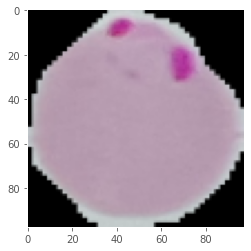

In [15]:
# Loading the image into memory 
img = cv2.imread(imagePath); 

# Setting the dimensions for the loaded image to be converted into and displaying the shape of the image 
print("Loaded Image Shape: {}".format(img.shape)); 
dim = (IMG_HEIGHT, IMG_WIDTH); 

# Resizing the image 
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA); 
plt.grid(False) 
plt.imshow(img) 
plt.show() 

In [16]:
# Expanding the image dimensions 
image = np.expand_dims(img, axis = 0); 

# Making Final Predictions 
result = model.predict_classes(image)
# Creating a loop to get the actual predicted class 
for key, value in (train_data_gen.class_indices.items()): 
    if value == result: 
        print("The Predicted Class is: {}".format(key))

The Predicted Class is: Parasitized
